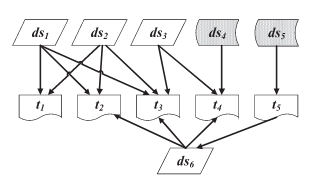

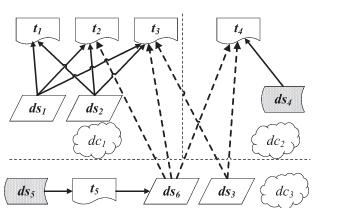

## Optimal data transmission strategy = [1, 1, 3, 2, 3]
## Optimal data transmission time = 1023s

In [1]:
import os
from typing import List
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
DC_CLOUD = 0
DC_EDGE = 1

DS_PUBLIC = 0
DS_PRIVATE = 1

DS_INIT = 0
DS_GEN = 1

NUM_DATACENTRES = 3
NUM_DATASETS = 5
NUM_TOTAL_DATASETS = 6
NUM_TASKS = 5

datacentres = []
datasets = []
tasks = []
task_dependencies = []
bandwidth = []

In [3]:
def logical_xor(a, b):
    if bool(a) == bool(b):
        return 0
    return 1

def random_integer(low, high, K = -1):
    r = random.randint(low, high)
    while(r == K):
        r = random.randint(low, high)
    return r


In [4]:
def fix_private_dataset_locations(particle):
    for i in range(len(particle)):
        if(datasets[i].ds_type == DS_PRIVATE):
            particle[i] = datasets[i].lc.index
            
def get_public_dataset_positions(datasets):
    public_datasets_positions = []
    for i in range(len(datasets)):
        if(datasets[i].ds_type == DS_PUBLIC and datasets[i].input_ds_type == DS_INIT):
            public_datasets_positions.append(i)
    
    return public_datasets_positions

In [5]:
def tasks_placement_feasibility(dataset_to_datacenter, task_dc_placements):
    datacentre_usage = [0] * NUM_DATACENTRES
    feasibility = True
    invalid_dc = None
    
    for i in range(len(dataset_to_datacenter)):
        datacentre_usage[dataset_to_datacenter[i]-1] += datasets[i].size
        
    for i in range(NUM_TASKS):
        task = tasks[i]
        task_dc = datacentres[task_dc_placements[i]-1]
        
        for ids in task.ids:
            if(dataset_to_datacenter[ids.index-1] != task_dc.index):
                datacentre_usage[task_dc.index-1] += ids.size
                if(datacentre_usage[task_dc.index-1] >= task_dc.capacity):
                    feasibility = False
                    print("Here")
                    invalid_dc = task_dc
                
        for ods in task.ods:
            if(dataset_to_datacenter[ods.index-1] != task_dc.index):
                datacentre_usage[task_dc.index-1] += ods.size
                if(datacentre_usage[task_dc.index-1] >= task_dc.capacity):
                    feasibility = False
                    print("Here")
                    invalid_dc = task_dc
                
    return datacentre_usage, feasibility, task_dc

# Initializing the problem variables

In [6]:
DC_CLOUD = 0
DC_EDGE = 1

DS_PUBLIC = 0
DS_PRIVATE = 1

DS_INIT = 0
DS_GEN = 1

NUM_DATACENTRES = 3
NUM_DATASETS = 5
NUM_TOTAL_DATASETS = 6
NUM_TASKS = 5

In [7]:
class datacentre(object):
    def __init__(self, dc_type: int, capacity: int, index: int):
        self.capacity = capacity
        self.dc_type = dc_type
        self.index = index
        
    def __str__(self):
        return (str(self.capacity))

class dataset(object):
    def __init__(self, size: int, gt: int, lc: datacentre, flc,
                 ds_type: int, input_ds_type: int, index: int):
        self.size = size
        self.gt = gt #Generating task
        self.lc = lc #dc location
        self.flc = flc #dc final location
        self.ds_type = ds_type #public or private
        self.input_ds_type = input_ds_type #input or generated dataset
        self.index = index

    def __str__(self):
        return (str(self.size) + str(self.ds_type))
        
        
class task(object):
    def __init__(self, ids: List[int] , ods: List[int], index: int):
        self.ids = ids #input dataasets
        self.ods = ods #output dataset
        self.index = index
        
    def __str__(self):
        return (str(self.ids) + " " + str(self.ods))
            

# Initializing data centre storage constraints, bandwidth and data set sizes

In [8]:
datacentres = []
datasets = []
tasks = []
task_dependencies = []
bandwidth = []

def initialize_dc():
    dc1 = datacentre(DC_CLOUD, 10000, 1)
    dc2 = datacentre(DC_EDGE, 20, 2)
    dc3 = datacentre(DC_EDGE, 20, 3)
    
    datacentres.extend([dc1, dc2, dc3])
    
def initialize_ds():
    ds1 = dataset(3, None, None, [], DS_PUBLIC, DS_INIT, 1)
    ds2 = dataset(5, None, None, [], DS_PUBLIC, DS_INIT, 2)
    ds3 = dataset(3, None, None, [], DS_PUBLIC, DS_INIT, 3)
    ds4 = dataset(3, None, datacentres[1], [datacentres[1]], DS_PRIVATE, DS_INIT, 4)
    ds5 = dataset(5, None, datacentres[2], [datacentres[2]], DS_PRIVATE, DS_INIT, 5)
    ds6 = dataset(8, None, None, [], DS_PUBLIC, DS_GEN,6)
    
    datasets.extend([ds1, ds2, ds3, ds4, ds5, ds6])
    

def initialize_tasks():
    t1 = task([datasets[0], datasets[1]], [], 1)
    t2 = task([datasets[0], datasets[1], datasets[5]], [], 2)
    t3 = task([datasets[0], datasets[1], datasets[2], datasets[5]], [], 3)
    t4 = task([datasets[2], datasets[3], datasets[5]], [], 4)
    t5 = task([datasets[4]], [datasets[5]], 5)
    
    tasks.extend([t1, t2, t3, t4, t5])
    

def initialize_task_dep():
    global task_dependencies
    task_dependencies = [[] for i in range(NUM_TASKS)]
    task_dependencies[4].extend([1,2,3])
    
    
def initialize_bandwidth():
    global bandwidth
    bandwidth = [[0] * NUM_DATACENTRES for i in range(NUM_DATACENTRES)]
    bandwidth[0][1] = bandwidth[1][0] = 10
    bandwidth[0][2] = bandwidth[2][0] = 20
    bandwidth[1][2] = bandwidth[2][1] = 150
    
initialize_dc()
initialize_ds()
initialize_tasks()
initialize_task_dep()
initialize_bandwidth()

In [9]:
#Topologically sort tasks
#Place task in datacentre with minimal transmission time
#After placing task place output tasks in same data centre
#Calculate Ttotal

    
# A recursive function used by topologicalSort
def topologicalSortUtil(v,visited,stack):

    visited[v] = True

    for i in task_dependencies[v]:
        if visited[i] == False:
            topologicalSortUtil(i,visited,stack)

    stack.insert(0,v)

def topologicalSort():

    visited = [False]*NUM_TASKS
    stack =[]

    for i in range(NUM_TASKS):
        if visited[i] == False:
            topologicalSortUtil(i,visited,stack)

    print(stack)
    return stack
        
sorted_tasks = topologicalSort()

[4, 3, 2, 1, 0]


# Map from particle to task placement, feasibility and transmission time

In [10]:
def place_tasks(particle, datacentre_usage):
    #Map from dataset to datacentre index (1 indexed)
    dataset_to_datacenter = [0] * NUM_TOTAL_DATASETS
    
    #Copy initial particle dataset to datacnetre map to this map
    for i in range(len(particle)):
        dataset_to_datacenter[i] = particle[i]
    #print(dataset_to_datacenter)
        
        
    task_datacentres = [0] * NUM_TASKS
    transmission_times = [0] * NUM_TASKS
    datacentre_usage = [0] * NUM_DATACENTRES
    
    
    #Initial datacentre storage calculation using particle
    for i in range(len(particle)):
        datacentre_usage[particle[i]-1] += datasets[i].size
        if(datacentre_usage[particle[i]-1] > datacentres[particle[i]-1].capacity):
            return False, 10000, None, None
        
    print(datacentre_usage)
    
    particle_valid = True
    invalid_dc = None

    #Iterate through tasks in topologically sorted order
    for i in range(NUM_TASKS):
        print("\n\n\n")
        transmission_time = 10000
        datacentre = None
        
        task = tasks[sorted_tasks[i]]
        
        #Check if the task requires any private dataset
        private_dataset_input = 0
        for ids in task.ids:
            if(ids.ds_type == DS_PRIVATE):
                datacentre = ids.lc
                private_dataset_input = 1
                print("Private ids " + str(ids.index) + " found in datacenter " + 
                    str(dataset_to_datacenter[ids.index-1]))
        
        #Private dataset required for this task, hence task should be placed in
        # datacentre in which private dataset is present
        
        if(private_dataset_input == 1):
            transmission_time_i = 0
            
            #Iterate through the input datasets of task to determine the other datasets
            # which should be transmitted to this datacentre
            for ids in task.ids:
                print("Input dataset " + str(ids.index))
                idc = dataset_to_datacenter[ids.index-1]
                print("Input dataset resides in " + str(idc))
                if(idc != (datacentre.index)):
                    transmission_time_i += ids.size * 1000 / (bandwidth[idc-1][datacentre.index-1])
                    print("Transmitting dataset " + str(ids.index) +  " to datacentre " + str(datacentre.index))
            #Iterate through output datasets of task to place output dataset in the particular datacentre

            for ids in task.ids:
                if(dataset_to_datacenter[ids.index-1] == datacentre.index):
                    continue
                if(datacentre_usage[datacentre.index-1] + ids.size > datacentre.capacity):
                    particle_valid = False
                    invalid_dc = datacentre
                datacentre_usage[datacentre.index-1] += ids.size

            for ods in task.ods:
                if(datacentre_usage[datacentre.index-1] + ods.size > datacentre.capacity):
                    particle_valid = False
                    invalid_dc = datacentre

                dataset_to_datacenter[ods.index-1] = datacentre.index
                datacentre_usage[datacentre.index-1] += ods.size

            transmission_times[task.index-1] = (transmission_time_i)
            task_datacentres[task.index-1] = (datacentre.index)
            print(datacentre_usage)

        #No private dataset in input dataset of task
        #Need to iterate through all daatacentres and choose the one with minimal transmission time
        
        else:
            transmission_time_i = 10000
            datacentre = None
            
            #Iterating through datacentres
            for j in range(NUM_DATACENTRES):
                temp = datacentre_usage[:]
                dc_valid = True
                print("\n")
                task_dc = datacentres[j]
                transmission_time_dcj = 0
                print("Placing task " + str(task.index) + " in datacentre " + str(task_dc.index))

                for ids in task.ids:
                    print("Input dataset " + str(ids.index))
                    idc = dataset_to_datacenter[ids.index-1]
                    print("Input dataset resides in " + str(idc))
                    if(idc != task_dc.index):
                        transmission_time_dcj += ids.size * 1000 / (bandwidth[idc-1][task_dc.index-1])
                        print("Transmitting dataset " + str(ids.index) +  " to datacentre " + str(task_dc.index) 
                            + " in " + str(ids.size * 1000 / (bandwidth[idc-1][task_dc.index-1])))
                        
                        temp[task_dc.index-1] += ids.size
                        if(temp[task_dc.index-1] > task_dc.capacity):
                            dc_valid = False
                            
                for task in task.ods:
                    temp[task_dc.index-1] += ods.size
                    if(temp[task_dc.index-1] > task_dc.capacity):
                        dc_valid = False
                        
                if (transmission_time_dcj < transmission_time_i):
                    backup_dc = task_dc
                        
                #Record the datacentre which is valid and produces minimal transmission time
                if (dc_valid and transmission_time_dcj < transmission_time_i):
                    print("Lower transmission found " + str(transmission_time_dcj))
                    transmission_time_i = transmission_time_dcj
                    datacentre = task_dc
            
            if(datacentre == None):
                particle_valid = False
                datacentre = backup_dc
                invalid_dc = backup_dc
                
            print("\n")
            print("Finally placing task " + str(task.index) + " in " + str(datacentre.index))
            for ids in task.ids:
                if(dataset_to_datacenter[ids.index-1] == datacentre.index):
                    continue
                datacentre_usage[datacentre.index-1] += ids.size
                
            #Iterate through output datasets of task to place output dataset in the particular datacentre
            for ods in task.ods:
                dataset_to_datacenter[ods.index-1] = datacentre.index-1
                datacentre_usage[datacentre.index-1] += ods.size
                #print("Adding output dataset " + str(ods.index) + " to datacentre " + str(datacentre.index))
                
            print("Appending " + str(transmission_time_i) + " " + str(datacentre.index))
            transmission_times[task.index-1] = (transmission_time_i)
            task_datacentres[task.index-1] = (datacentre.index)
            
    print(datacentre_usage)
    return particle_valid, np.sum(transmission_times), task_datacentres, invalid_dc

In [11]:
def fitness(particle):
    
    particle_feasibility, total_transmission_time, task_datacentres, invalid_datacentre = place_tasks(particle, [0] * NUM_DATACENTRES)
    return particle_feasibility, total_transmission_time, invalid_datacentre


def compare_fitness(particle1, particle2):
    feasibility1, fitness_score1, invalid_datacentre1 = fitness(particle1)
    feasibility2, fitness_score2, invalid_datacentre2 = fitness(particle2)
    
    feasibility = feasibility1
    if(logical_xor(feasibility1, feasibility2) == 0):
        if(fitness_score1 < fitness_score2):
            return feasibility, particle1, fitness_score1
        return feasibility, particle2, fitness_score2
    
    else:
        if(feasibility1 == True):
            return True, particle1, fitness_score1
        return True, particle2, fitness_score2

# Genetic algorithm operators

In [12]:
public_datasets_positions = get_public_dataset_positions(datasets)

In [13]:

def mutation(particle, w, public_dataset_positions):
    
    r = random.uniform(0, 1)
    if (r > w):
        return particle
    
    feasibility, fitness_score, invalid_datacentre = fitness(particle)

    new_particle = particle
    mutation_index = random.choice(public_dataset_positions)
    if(feasibility == True):

        random_datacentre = random_integer(1, NUM_DATACENTRES, new_particle[mutation_index])
        new_particle[mutation_index] = random_datacentre
        
    else:
        for i in range(len(new_particle)):
            if(new_particle[i] == invalid_datacentre.index and datasets[i].ds_type == DS_PUBLIC):
                random_datacentre = random_integer(1, NUM_DATACENTRES, new_particle[i])
                new_particle[mutation_index] = random_datacentre
                
    return new_particle

In [14]:
def crossover(particle1, particle2, c):
    r = random.uniform(0, 1)
    if (r > c):
        return particle1
    
    new_particle = [0] * NUM_DATASETS
    index1 = random_integer(0, len(particle1) - 1)
    index2 = random_integer(0, len(particle1) - 1, index1)
    
    #print("Indexes are " + str(index1) + " " + str(index2))
    
    if(index1 > index2):
        temp = index1
        index1 = index2
        index2 = temp
    
    for i in range(len(particle1)):
        if(i < index1):
            new_particle[i] = particle1[i]
        elif (i <= index2):
            new_particle[i] = particle2[i]
        else:
            new_particle[i] = particle1[i]
    
    #fix_private_dataset_locations(new_particle)
    
    return new_particle

# GA_DPSO hyperparameters initialization

In [15]:
INITIAL_POPULATION = 10

MAX_W = 0.9
MIN_W = 0.4

C1_START = 0.9
C1_END = 0.4

C2_START = 0.9
C2_END = 0.4

NUM_ITERATIONS = 10

# 1. Population Creation

In [16]:
particles = []
pbest = []
gbest = None
gbest_fitness = -1
def initialize_population():
    for i in range(INITIAL_POPULATION):
        particle = np.random.randint(1, NUM_DATACENTRES+1, NUM_DATASETS)
        fix_private_dataset_locations(particle)
        particles.append(particle)
        pbest.append(particle)
        print(particle)
        
        
initialize_population()
gbest = particles[0]
for i in range(1, INITIAL_POPULATION):
    _, gbest, gbest_fitness = compare_fitness(gbest, particles[i])

[1 3 2 2 3]
[2 2 3 2 3]
[1 3 2 2 3]
[2 3 3 2 3]
[2 1 3 2 3]
[3 1 1 2 3]
[3 2 3 2 3]
[1 3 2 2 3]
[2 2 3 2 3]
[2 3 3 2 3]
[3, 6, 10]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[3, 6, 18]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[3, 14, 18]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0
Input dataset 3
Input dataset resides in 2
Transmitting dataset 3 to datacentre 1 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 950.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 3
Tran

Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resi

In [17]:
# Fitness function for each particle in the population
# Choose pbest and gbest from the population
# 1 2
#pbest 1 2
# gbest = particle with maxfitness(1,2)

# 1a 2a
#pbest(1) = particle with maxfitness(1,1a)

#gbest = particle with maxfitness(prevgbest ,all pbest)

# Update function

In [18]:
def update(particle, w, pbest, c1, gbest, c2):
    w = w
    new_particle = particle
    new_particle = mutation(new_particle, w, public_datasets_positions)
    
    print(new_particle)
    print(pbest)
    print(gbest)
    new_particle = crossover(new_particle, pbest, c1)
    new_particle = crossover(new_particle, gbest, c2)
    
    return new_particle

# GA-DPSO iterations (Calculate Fitness, update Pbest and Gbest, Update, Repeat)

In [19]:
import time
start_time = time.time()
gbest_scores = []
pbest_scores =[[] for _ in range(0,NUM_ITERATIONS+1)]

for i in range(len(particles)):
    pbest_scores[0].append(fitness(particles[i])[1])

gbest_scores.append(gbest_fitness)
for gen in range(1,NUM_ITERATIONS+1):
    w = MAX_W - gen/100 * (MAX_W - MIN_W)
    c1 = C1_START - gen/100 * (C1_START- C1_END)
    c2 = C2_START - gen/100 * (C2_START- C2_END)
    updated_particles = particles
    for i in range(len(particles)):
        updated_particles[i] = update(particles[i], w, pbest[i], c1, gbest, c2)
        
        pbest_feasibility, pbest[i], pbest_fitness = compare_fitness(pbest[i], updated_particles[i])
        if(pbest_feasibility or i==0):
            pbest_scores[gen].append(pbest_fitness)
        else:
            pbest_scores[gen].append(pbest_scores[gen][-1])
        gbest_feasibility, gbest, gbest_fitness = compare_fitness(gbest, pbest[i])
        
    gbest_scores.append(gbest_fitness)
end_time = time.time()

[3, 6, 10]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[3, 6, 18]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[3, 14, 18]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0
Input dataset 3
Input dataset resides in 2
Transmitting dataset 3 to datacentre 1 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 950.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336
Input dataset 3
Input dataset resides in 2
Input dataset 6
Inpu

Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 550.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Lower transmission found 150.0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in

Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 i

Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 550.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 3
Trans

Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 650.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0
Lower transmission found 250.0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 3


Finally placing task 1 in 1
Appending 250.0 1
[37, 14, 21]
[0, 6, 13]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[0, 6, 21]




Private 




Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 850.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
I

Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[11, 14, 13]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
I

Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 400.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resi

Transmitting dataset 2 to datacentre 1 in 250.0
Input dataset 3
Input dataset resides in 2
Transmitting dataset 3 to datacentre 1 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 950.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336
Input dataset 3
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 3
Input dataset 3
Input dataset resides in 2
Transmitting dataset 3 to datacentre 3 in 20.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 950.0 1






Placing ta

Input dataset 2
Input dataset resides in 3
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 950.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 950.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input datas

Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 950.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input dataset resides in 3
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 950.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0


Transmitting dataset 2 to datacentre 1 in 500.0
Lower transmission found 800.0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 2
Lower transmission found 0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input dataset resides in 2
Transmitting dataset 2 to datacentre 3 in 33.333333333333336


Finally placing task 1 in 2
Appending 0 2
[35, 22, 13]
[11, 3, 5]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[11, 3, 13]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[11, 14, 13]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
In

[11, 3, 5]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[11, 3, 13]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[11, 14, 13]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in

Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in

Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitti

Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input data

Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Tra

Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[11, 3, 13]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[11, 14, 13]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting

Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 

Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 650.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 650.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0
Lower transmission found 250.0


Placing t

Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to d







Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]


Input dataset resides in 3


Finally placing task 2 in 1
Appending 700.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input dataset 2
Input dataset resides in 1
Lower transmission found 300.0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 300.0 1
[33, 17, 16]
[2, 3, 3, 2, 3]
[2, 3, 3, 2, 3]
[1, 1, 3, 2, 3]
[0, 6, 13]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[0, 6, 21]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input 

Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 25

Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 

Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[5, 14, 19]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 700.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.33333

Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in

Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input datase

Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[3, 1, 3, 2, 3]
[3, 1, 3, 2, 3]
[1, 1, 3, 2, 3]
[5, 3, 11]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[5, 3, 19]




Private ids 4 found in datacenter 2
Inpu

Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 550.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Lower transmission found 150.0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Inpu

Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 700.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 700.0 1






Placing task 2 in datacentre 1
Input dataset 

Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dat

Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitti

Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 13]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1




Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 700.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.




Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3



Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 700.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 700.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input da

Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 3
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 800.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 650.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336


Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datace

[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 2


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 400.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to da

Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Final

[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to data

Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1




Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre

Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to d

Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 850.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 700.0


Placing task 2 in datacentre 

Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 3 in 150.0
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 400.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transm

Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 i



Finally placing task 3 in 1
Appending 1050.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 2
Transmitting dataset 2 to datacentre 1 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 900.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 2
Transmitting dataset 2 to datacentre 3 in 33.333333333333336
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 900.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset r

Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 3


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input da

Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input datase

Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 850.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 3 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 850.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input dataset 2
Input dataset resides in 1
Input dataset 

Input dataset 2
Input dataset resides in 1
Lower transmission found 150.0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 150.0 1
[33, 14, 19]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 13]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre

Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[5, 17, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 2
Transmitting dataset 1 to datacentre 1 in 300.0
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 850.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 2
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 2
Tra

Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336




Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[1, 2, 3, 2, 3]
[1, 2, 3, 2, 3]
[1, 1, 3, 2, 3]
[3, 8, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[3, 8, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transm

Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing ta

Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datace

Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 700.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 

Input dataset 5
Input dataset resides in 3
[8, 6, 13]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 13]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 2
Transmitting dataset 3 to datacentre 1 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 700.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacent

Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[5, 3, 11]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[5, 3, 19]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[5, 14, 19]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input datas

Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset

Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to dat

Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting data

Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre

Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 800.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 2 in 33.333333333333336
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 3
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 800.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 3
Transmitting dataset 2 to datacentre 1 in 250.0


Input dataset resides in 3
Transmitting dataset 1 to datacentre 1 in 150.0
Input dataset 2
Input dataset resides in 1
Lower transmission found 150.0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 3
Transmitting dataset 1 to datacentre 2 in 20.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 3
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 150.0 1
[33, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 1
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dat

Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 400.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
In

Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Tr

Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0


Finally placing task 1 in 1
Appending 0 1
[27, 14, 16]
[5, 6, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[5, 6, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Tran

Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 2 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 6
Input dataset resides in 3


Finally placing task 2 in 1
Appending 400.0 1






Placing task 1 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Lower transmission found 0


Placing task 1 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0


Placing task 1 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input data


Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 2
Transmitting dataset 3 to datacentre 1 in 300.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 700.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 2
Transmitting dataset 3 to datacentre 3 in 20.0
In



Finally placing task 1 in 1
Appending 0 1
[27, 14, 13]
[8, 3, 8]




Private ids 5 found in datacenter 3
Input dataset 5
Input dataset resides in 3
[8, 3, 16]




Private ids 4 found in datacenter 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset

Input dataset 2
Input dataset resides in 2
Transmitting dataset 2 to datacentre 1 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 1050.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 2
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 2
Transmitting dataset 2 to datacentre 3 in 33.333333333333336
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing ta

Transmitting dataset 3 to datacentre 2
Input dataset 4
Input dataset resides in 2
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2
[8, 14, 16]






Placing task 3 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 1 in 150.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 550.0


Placing task 3 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500.0
Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Tra

Input dataset 3
Input dataset resides in 3
Transmitting dataset 3 to datacentre 2 in 20.0
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 2 in 53.333333333333336


Placing task 3 in datacentre 3
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 3 in 150.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 3 in 250.0
Input dataset 3
Input dataset resides in 3
Input dataset 6
Input dataset resides in 3


Finally placing task 3 in 1
Appending 550.0 1






Placing task 2 in datacentre 1
Input dataset 1
Input dataset resides in 1
Input dataset 2
Input dataset resides in 1
Input dataset 6
Input dataset resides in 3
Transmitting dataset 6 to datacentre 1 in 400.0
Lower transmission found 400.0


Placing task 2 in datacentre 2
Input dataset 1
Input dataset resides in 1
Transmitting dataset 1 to datacentre 2 in 300.0
Input dataset 2
Input dataset resides in 1
Transmitting dataset 2 to datacentre 2 in 500

# Optimal data placement strategy and transmission time

In [20]:
if(gbest_feasibility):
    print(gbest)
    print(gbest_fitness)
else:
    print("No valid placement strategy found")
    
print("Time is " + str(end_time - start_time))

[1, 1, 3, 2, 3]
1023.3333333333334
Time is 8.232993602752686


In [21]:
# Pep8 standards - https://www.python.org/dev/peps/pep-0008/#id39 
# Enum -https://docs.python.org/3/library/enum.html#creating-an-enum 
# Keyword arguments for Dataset (any class with large number of args)
# Pass arrays to function instead of global
# Float(inf) for large numbers
# Calculate transmission time for infeasible particles - Done
# Plot for pbest(min, max, avg), gbest, pcur(min, avg)

In [22]:
pbest_min = np.min(pbest_scores, axis=0).tolist()
pbest_avg = np.mean(pbest_scores, axis = 0).tolist()
pbest_max = np.max(pbest_scores, axis = 0).tolist()

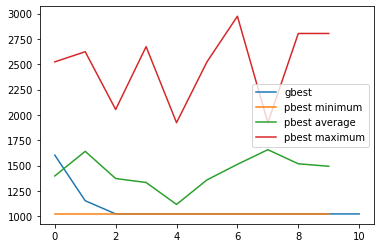

In [23]:
plt.plot(gbest_scores, label= 'gbest')
plt.plot(pbest_min, label= 'pbest minimum')
plt.plot(pbest_avg, label= 'pbest average')
plt.plot(pbest_max, label= 'pbest maximum')
plt.legend()
plt.show()

In [24]:
#type hints and docstring
